# Trace Analysis Examples

## Idle States Residency Analysis

This notebook shows the features provided by the idle state analysis module. It will be necessary to collect the following events:

 - `cpu_idle`, to filter out intervals of time in which the CPU is idle
 - `sched_switch`, to recognise tasks on kernelshark
 
Details on idle states profiling ar given in **Per-CPU/Per-Cluster Idle State Residency Profiling** below.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2016-12-07 18:19:51,925 INFO    : root         : Using LISA logging configuration:
2016-12-07 18:19:51,925 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# DataFrame support
from pandas import DataFrame

## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

Our target is a Juno R0 development board running Linux.

In [3]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    
    # Target board IP/MAC address
    "host"        : '192.168.0.1',
    
    # Login credentials
    "username"    : 'root',
    "password"    : 'juno',
    
    "results_dir" : "IdleAnalysis",
    
    # RTApp calibration values (comment to let LISA do a calibration run)
    "rtapp-calib" :  {
        "0": 318, "1": 125, "2": 124, "3": 318, "4": 318, "5": 319
    },
    
    # Tools required by the experiments
    "tools"   : ['rt-app', 'trace-cmd'],
    "modules" : ['bl', 'cpufreq', 'cpuidle'],
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

In [4]:
# Initialize a test environment
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2016-12-07 18:19:55,077 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-07 18:19:55,078 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-07 18:19:55,078 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2016-12-07 18:19:55,079 INFO    : TestEnv      : Connecting linux target:
2016-12-07 18:19:55,079 INFO    : TestEnv      :   username : root
2016-12-07 18:19:55,080 INFO    : TestEnv      :       host : 192.168.0.1
2016-12-07 18:19:55,080 INFO    : TestEnv      :   password : juno
2016-12-07 18:19:55,081 INFO    : TestEnv      : Connection settings:
2016-12-07 18:19:55,081 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2016-12-07 18:20:04,495 INFO    : TestEnv      : Initializing target workdir:
2016-12-07 18:20:04,497 INFO    : TestEnv      :    /root/devlib-target
2016-12-07 18:20:28,575 INFO    : TestEnv      : Topology:
2016-12-07 18:20:28,576 INFO    : TestEnv 

## Workload configuration and execution

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

In [5]:
def experiment(te):

    # Create RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2016-12-07 18:20:39,906 INFO    : Workload     : Setup new workload ramp
2016-12-07 18:20:39,907 INFO    : Workload     : Workload duration defined by longest task
2016-12-07 18:20:39,908 INFO    : Workload     : Default policy: SCHED_OTHER
2016-12-07 18:20:39,908 INFO    : Workload     : ------------------------
2016-12-07 18:20:39,908 INFO    : Workload     : task [ramp], sched: using default policy
2016-12-07 18:20:39,909 INFO    : Workload     :  | calibration CPU: 1
2016-12-07 18:20:39,909 INFO    : Workload     :  | loops count: 1
2016-12-07 18:20:39,909 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (5 loops)
2016-12-07 18:20:39,910 INFO    : Workload     : |  period   100000 [us], duty_cycle  60 %
2016-12-07 18:20:39,910 INFO    : Workload     : |  run_time  60000 [us], sleep_time  40000 [us]
2016-12-07 18:20:39,910 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (5 loops)
2016-12-07 18:20:39,911 INFO    : Workload     : |  period   100000 [us], d

## Parse trace and analyse data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2016-12-07 18:21:31,546 INFO    : root         : Content of the output folder /home/vagrant/lisa/results/IdleAnalysis


/home/vagrant/lisa/results/IdleAnalysis
├── cluster_idle_state_residency.png
├── cpu_idle_state_residency.png
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 9 files


In [8]:
trace = Trace(te.platform, res_dir, events=my_conf['ftrace']['events'])

2016-12-07 18:21:32,410 INFO    : Trace        : Parsing FTrace format...
2016-12-07 18:21:32,664 WARNING : Trace        : Failed to load tasks names from trace events
2016-12-07 18:21:32,665 INFO    : Trace        : Collected events spans a 14.858 [s] time interval
2016-12-07 18:21:32,665 INFO    : Trace        : Set plots time range to (0.000000, 14.857782)[s]
2016-12-07 18:21:32,666 INFO    : Analysis     : Registering trace analysis modules:
2016-12-07 18:21:32,667 INFO    : Analysis     :    tasks
2016-12-07 18:21:32,668 INFO    : Analysis     :    status
2016-12-07 18:21:32,669 INFO    : Analysis     :    frequency
2016-12-07 18:21:32,670 INFO    : Analysis     :    cpus
2016-12-07 18:21:32,671 INFO    : Analysis     :    latency
2016-12-07 18:21:32,673 INFO    : Analysis     :    idle
2016-12-07 18:21:32,674 INFO    : Analysis     :    functions
2016-12-07 18:21:32,675 INFO    : Analysis     :    eas


## Per-CPU Idle State Residency Profiling

It is possible to get the residency in each idle state of a CPU or a cluster with the following commands:

In [9]:
# Idle state residency for CPU 3
CPU=3
state_res = trace.data_frame.cpu_idle_state_residency(CPU)
state_res

,time
idle_state,
0,0.009255
1,0.003381
2,14.483522


For the translation between the idle value and its description:

In [10]:
DataFrame(data={'value':  state_res.index.values,
                'name': [te.target.cpuidle.get_state(i, cpu=CPU) for i in state_res.index.values]})

,name,value
0,"CpuidleState(WFI, ARM64 WFI)",0
1,"CpuidleState(cpu-sleep-0, cpu-sleep-0)",1
2,"CpuidleState(cluster-sleep-0, cluster-sleep-0)",2


The **IdleAnalysis** module provide methods for plotting residency data:

In [11]:
ia = trace.analysis.idle

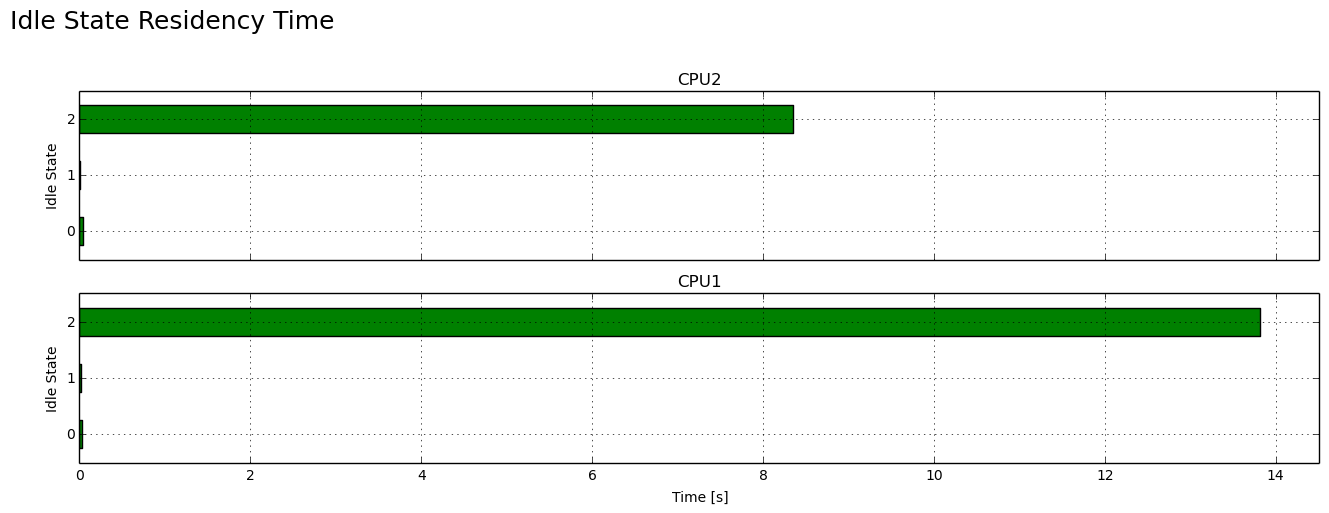

In [12]:
# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([1,2])

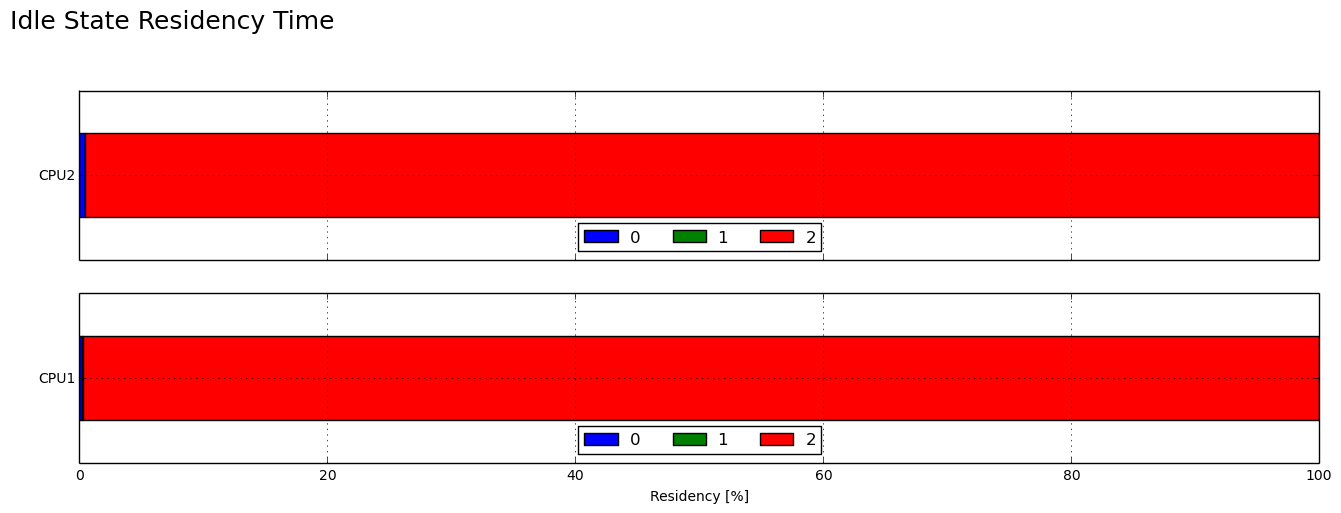

In [13]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([1,2], pct=True)

## Per-cluster Idle State Residency

In [14]:
# Idle state residency for CPUs in the big cluster
trace.data_frame.cluster_idle_state_residency('big')

,time
idle_state,
0,0.022823
1,0.010507
2,7.827988


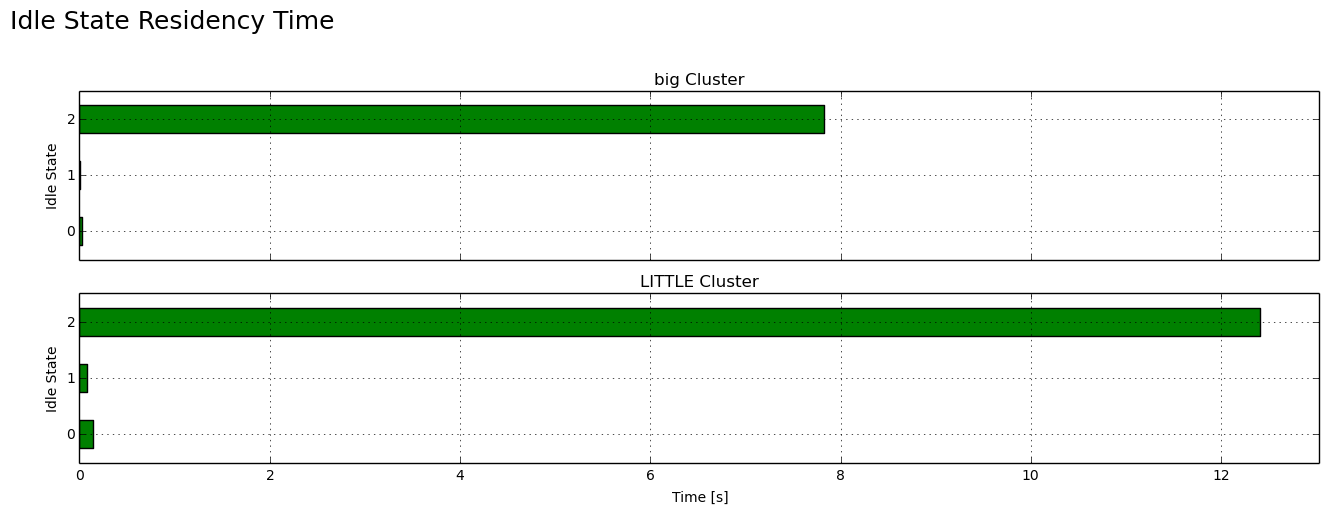

In [15]:
# Actual time spent in each idle state for CPUs in the big and LITTLE clusters
ia.plotClusterIdleStateResidency(['big', 'LITTLE'])

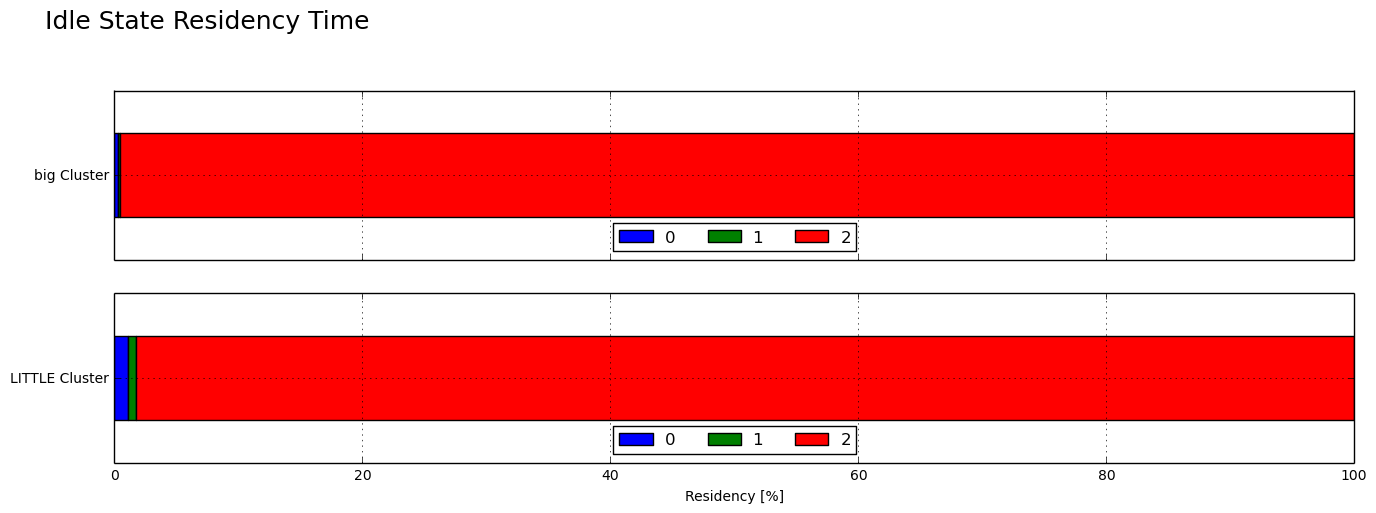

In [16]:
# Percentage of time spent in each idle state for CPUs in the big and LITTLE clusters
ia.plotClusterIdleStateResidency(['big', 'LITTLE'], pct=True)